configuration parameters below optimize Spark configuration to the data.

In [1]:
%%configure -f
{ "conf":{
     "spark.pyspark.python": "python3"
    ,"spark.pyspark.virtualenv.enabled": "true"
    ,"spark.kubernetes.executor.node.selector.node-lifecycle":"spot"
    ,"spark.pyspark.virtualenv.type":"native"
    ,"spark.pyspark.virtualenv.bin.path":"/usr/bin/virtualenv"
    ,"spark.sql.files.ignoreCorruptFiles":"true"
    ,"spark.dynamicAllocation.executorIdleTimeout":"18000"
    ,"spark.driver.memory":"32g"
    ,"spark.driver.cores":"32"
    ,"spark.driver.maxResultSize":"24g"
    ,"spark.executor.memory":"32g"
    ,"spark.network.timeout":"300"
    ,"spark.executor.cores":"6"
    ,"spark.yarn.executor.Overhead":"12g"
    ,"spark.dynamicAllocation.maxExecutors":"500"
    ,"livy.server.session.timeout":"24h"
    ,"spark.sql.shuffle.partitions":"15000"
         }
}  

[I 2023-05-31 12:12:45,174.174 configure_magic] Magic cell payload received: {"conf": {"spark.pyspark.python": "python3", "spark.pyspark.virtualenv.enabled": "true", "spark.kubernetes.executor.node.selector.node-lifecycle": "spot", "spark.pyspark.virtualenv.type": "native", "spark.pyspark.virtualenv.bin.path": "/usr/bin/virtualenv", "spark.sql.files.ignoreCorruptFiles": "true", "spark.dynamicAllocation.executorIdleTimeout": "18000", "spark.driver.memory": "32g", "spark.driver.cores": "32", "spark.driver.maxResultSize": "24g", "spark.executor.memory": "32g", "spark.network.timeout": "300", "spark.executor.cores": "6", "spark.yarn.executor.Overhead": "12g", "spark.dynamicAllocation.maxExecutors": "500", "livy.server.session.timeout": "24h", "spark.sql.shuffle.partitions": "15000"}, "proxyUser": "assumed-role_fdp_blitvin-Isengard"}

[I 2023-05-31 12:12:45,174.174 configure_magic] Sending request to update kernel. Please wait while the kernel will be refreshed.


The kernel is successfully refreshed.

In [1]:
#    ,"spark.sql.adaptive.enabled":"true"
#    ,"spark.sql.adaptive.coalescePartitions.enabled":"true"
#    ,"spark.sql.adaptive.coalescePartitions.initialPartitionNum":"1000"

https://towardsdatascience.com/basics-of-apache-spark-configuration-settings-ca4faff40d45
https://luminousmen.com/post/spark-tips-partition-tuning
https://sparkbyexamples.com/pyspark/pyspark-repartition-vs-partitionby/

In [2]:
import pandas as pd
import pyarrow
import s3fs
import fsspec
import matplotlib
import matplotlib.pyplot as plt
import pyspark.sql.functions as py_f
from pyspark.sql.window import Window

In [3]:
print(spark.version,"\n\n")
configurations = spark.sparkContext.getConf().getAll()
for conf in configurations:
    print(conf)


3.3.0-amzn-1 


('spark.kubernetes.executor.pod.allowlistFile', '/etc/spark/conf/executor-pod-template-pod-allowlist.txt')
('spark.eventLog.enabled', 'true')
('spark.eventLog.dir', 'file:///var/log/spark/apps')
('spark.kubernetes.memoryOverheadFactor', '0.4')
('spark.kubernetes.executor.podTemplateContainerName', 'spark-kubernetes-executor')
('spark.dynamicAllocation.maxExecutors', '500')
('spark.kubernetes.driverEnv.HTTP2_DISABLE', 'true')
('spark.sql.parquet.output.committer.class', 'com.amazon.emr.committer.EmrOptimizedSparkSqlParquetOutputCommitter')
('spark.driver.cores', '32')
('spark.blacklist.decommissioning.timeout', '1h')
('spark.kubernetes.driver.node.selector.node-lifecycle', 'on-demand')
('spark.kubernetes.driver.label.kernel_id', 'fe646132-3324-45e3-a0b1-486d99cb4b6a')
('spark.hadoop.dynamodb.customAWSCredentialsProvider', 'com.amazonaws.auth.WebIdentityTokenCredentialsProvider')
('spark.kubernetes.driver.container.allowlistFile', '/etc/spark/conf/driver-pod-template-cont

We analyzed the data published over the SIP feeds (CTA : CQS / CTS and UTP : UQDF / UTDF) and the depth of the book feeds of the 16 lit venues under the Reg. NMS system to see the impact of these proposed reforms on the quality of the market. 

Definitions 
Quoted spread = (bid - ask) / midpoint 
Spread -  bid - ask 

Results - 
1)	Number of current odd - lot trades within each bucket. & number of trades in each bucket. 
    a)	Graphic concentration 
    b)	– look for rationale & see if it is – 
2)	Average round-lot and odd-lot quoted spreads across each bucket 
    a)	matrix 
    b)	Heat map 
    c)	Hour of the day ? 
3)	Effect on market data-  
    a)	Anticipated increase in MD volumes - counts, etc
    b)	Number of direct feed updates where top of the book is an odd - lot
4)	Case study around AMZN stock split - 
    a)	Round lot spreads for AMZN per exchange - when high priced before the split
    b)	Odd-lot spreads for AMZN per exchange  - after the split. 


In [4]:
class MtRoundLot():
    def __init__(self,part_experiment_id, is_debug,debug_symbol='AMZN'):
        self.s3_dir_root="s3://maystreetdata/feeds_norm/mstnorm_parquet_0_5_0"
        self.s3_dir_root_prepped="s3://maystreetdata/feeds_norm/partition_scheme_experiments_7/mstnorm_parquet_0_5_0/"
        self.s3_dir_partition_experiments =f"s3://maystreetdata/feeds_norm/partition_scheme_experiments_{part_experiment_id}/mstnorm_parquet_0_5_0"
        self.s3_dir_root_results =f"s3://maystreetdata/analysis/"
        self.tables={"mt_roundlot_bbo":{"tables":[f"{self.s3_dir_root}/mt=bbo_quote/"]},
                     "mt_roundlot_nbbo":{"tables":[f"{self.s3_dir_root}/mt=nbbo_quote/"]},
                     "mt_oddlot":{"tables":[f"{self.s3_dir_root}/mt=aggregated_price_update/"]},
                     "mt_trade":{"tables":[f"{self.s3_dir_root}/mt=trade/"]}
                    }
        self.tables_prepped={"mt_roundlot_bbo":{"tables":[f"{self.s3_dir_root_prepped}/mt_roundlot_bbo.parquet"]},
                     "mt_roundlot_nbbo":{"tables":[f"{self.s3_dir_root_prepped}/mt_roundlot_nbbo.parquet"]},
                     "mt_oddlot":{"tables":[f"{self.s3_dir_root_prepped}/mt_oddlot.parquet"]}
                    }
        self.raw_df ={}
        self.raw_df_prepped ={}
        self.stats_df ={}
        self.data_validation ={}
        self.column_map={}
        self.joined_df={}
        self.column_map['mt_oddlot']={ 
            'ask':'AskPrice_1'
            ,'bid':'BidPrice_1'
            ,'timestamp':'LastExchangeTimestamp'
            ,'seq_number':'LastSequenceNumber'
            ,'BidQuantity':'BidQuantity_1'
            ,'AskQuantity':'AskQuantity_1'
            ,'partition_by':['Product','FeedType',"Feed","dt",'f','MarketParticipant','is_trading_hours','hour_est']
        }
        self.column_map['mt_roundlot_bbo']={
            'ask':'AskPrice'
            ,'bid':'BidPrice'
            ,'timestamp':'ExchangeTimestamp'
            ,'seq_number':'SequenceNumber'
            ,'BidQuantity':'BidQuantity'
            ,'AskQuantity':'AskQuantity'
            ,'partition_by':['Product','FeedType',"Feed","dt",'f','is_trading_hours','hour_est']
        }
        self.column_map['mt_roundlot_nbbo']={
            'ask':'AskPrice'
            ,'bid':'BidPrice'
            ,'timestamp':'ExchangeTimestamp'
            ,'seq_number':'SequenceNumber'
            ,'BidQuantity':'BidQuantity'
            ,'AskQuantity':'AskQuantity'
            ,'partition_by':['Product','FeedType',"Feed","dt",'f','is_trading_hours','hour_est']
        }
        self.round_factor=0.333333333333
        self.is_debug=is_debug
        self.debug_symbol=debug_symbol
        print(self.s3_dir_partition_experiments)
    def set_data_prepped(self,data_label):
        col_map=self.column_map.get(data_label)
        data_files = self.tables_prepped.get(data_label).get('tables')
        data_df=None
        for one_file in data_files:
            if self.is_debug:
                one_data_df=spark.read.parquet(one_file).where(f"Product=='{self.debug_symbol}'")
            else:
                one_data_df=spark.read.parquet(one_file)
            if data_df is None:
                data_df=one_data_df
            else:
                data_df=data_df.union(one_data_df)
        self.raw_df_prepped[f"{data_label}"]=data_df
    def set_data(self,data_label, is_raw=False):
        col_map=self.column_map.get(data_label)
        data_files = self.tables.get(data_label).get('tables')
        data_df=None
        for one_file in data_files:
            feed_filters = self.tables.get(data_label).get('feeds',None)
            path_parts= one_file.split("/")
            feed_type=path_parts[len(path_parts)-2:len(path_parts)-1][0]
            if feed_filters is not None:
                filter_string='"'+'","'.join(feed_filters)+'"'
                one_data_df = spark.read.parquet(one_file).filter(f'Feed in ({filter_string})') 
            else:
                one_data_df = spark.read.parquet(one_file)
            if self.is_debug:
                one_data_df=one_data_df.where(f"Product=='{self.debug_symbol}'")
            if 'f' not in one_data_df.columns:
                one_data_df = one_data_df.withColumn('f', py_f.col("Feed"))
            if data_df is None:
                data_df=one_data_df
            else:
                data_df=data_df.union(one_data_df)
            data_df = data_df.withColumn('FeedType', py_f.lit(feed_type))\
            .select('FeedType','Feed','f','Product',col_map['bid'],col_map['ask'],col_map['timestamp'],col_map['BidQuantity'],col_map['AskQuantity'])\
            .groupBy('FeedType','Feed','f','Product',col_map['timestamp']).agg(
                 py_f.round(py_f.max(col_map['bid']),3).alias(f'best_bid_{data_label}')
                ,py_f.round(py_f.min(col_map['ask']),3).alias(f'best_ask_{data_label}')
                ,py_f.round(py_f.max(col_map['BidQuantity']),3).alias(f'bid_quantity_{data_label}')
                ,py_f.round(py_f.max(col_map['AskQuantity']),3).alias(f'ask_quantity_{data_label}')
            ).withColumnRenamed('FeedType', f'FeedType_{data_label}')\
            .withColumnRenamed('Feed', f'Feed_{data_label}')\
            .withColumnRenamed(col_map['timestamp'], f'exchange_timestamp_{data_label}')\
            .withColumnRenamed('f', f'f_{data_label}')\
            .withColumn(f"mid_{data_label}",(py_f.col(f'best_ask_{data_label}')+py_f.col(f'best_bid_{data_label}'))/py_f.lit(2))\
            .withColumn(f"bid_ask_{data_label}",(py_f.col(f'best_ask_{data_label}')-py_f.col(f'best_bid_{data_label}'))/py_f.col(f"mid_{data_label}")) \
            .withColumn(f'timestamp_ts_utc_{data_label}',py_f.from_unixtime(py_f.col(f'exchange_timestamp_{data_label}')/1000/1000/1000))\
            .withColumn(f'timestamp_ts_est_{data_label}',py_f.from_utc_timestamp((py_f.from_unixtime(py_f.col(f'exchange_timestamp_{data_label}')/1000/1000/1000)),'America/New_York'))\
            .withColumn(f'time_ts_est_{data_label}',py_f.date_format(f'timestamp_ts_est_{data_label}', 'HH:mm:ss'))\
            .withColumn(f'hour_est_{data_label}',py_f.date_format(f'timestamp_ts_est_{data_label}', 'HH'))\
            .withColumn(f'date_est_{data_label}',py_f.date_format(f'timestamp_ts_est_{data_label}', 'yyyy-MM-dd'))\
            .withColumn(f'is_trading_hours', ((py_f.col(f'timestamp_ts_est_{data_label}')>=py_f.lit('09:30:00'))&(py_f.col(f'timestamp_ts_est_{data_label}')<=py_f.lit('15:59:00'))))
            
        part_by = [f'FeedType_{data_label}',"Product"]
        self.raw_df[f"{data_label}"]=data_df.repartition(15000,*part_by)
    def dv_universe(self):
        dv_key='universe_check'
        self.data_validation[dv_key]={}
        for one_key in self.raw_df.keys():
            one_df = self.raw_df.get(one_key)
            col_name = f"{one_key}_ticker_count"
            curr_count = one_df.agg(py_f.countDistinct("Product").alias(col_name)).collect()
            curr_count =    [i.__getitem__(col_name) for i in curr_count][0]
            self.data_validation[dv_key][one_key]=curr_count
    
    def dv_ts_unique(self):
        dv_key='ts_unique_check'
        self.data_validation[dv_key]={}
        for one_key in self.raw_df.keys():
            one_df = self.raw_df.get(one_key)
            col_map=self.column_map.get(one_key)
            ts_field=col_map.get('timestamp')
            seq_field=col_map.get('seq_number')
            count_alias,countDistinct_alias = f'count_{ts_field}',f'countDistinct_{ts_field}'
            uniq_ts_check = one_df.groupBy(col_map.get('partition_by')).agg(
                py_f.count(ts_field).alias(count_alias),py_f.countDistinct(ts_field,seq_field).alias(countDistinct_alias)
            ).where(f'{count_alias}>{countDistinct_alias}').count()
            self.data_validation[dv_key][one_key]=uniq_ts_check
    def set_volume_ptile(self):
        by_prod_feed=self.raw_df_prepped["mt_roundlot_nbbo"].groupBy('Product').count().orderBy('Product')
        by_prod_feed=by_prod_feed.select("Product",'count', 
            py_f.round((py_f.floor(py_f.percent_rank().over( Window.partitionBy().orderBy(by_prod_feed['count']))/py_f.lit(self.round_factor))*py_f.lit(self.round_factor)),1).alias("update_count_pctrank"))
        by_prod_feed=by_prod_feed.withColumn('volume_level',py_f.when(py_f.col('update_count_pctrank')==0.0,'low')\
                                                                                .otherwise(py_f.when(py_f.col('update_count_pctrank')==0.3,'moderate').otherwise('high'))).cache()
        #by_prod_feed.groupBy('update_count_pctrank').count()
        self.volume_rank_df = by_prod_feed

    def set_common_universe(self):
        bbo_nbbo_cols = ['Product','Feed','dt','f','bidask_spread_timew_avg','data_count','is_trading_hours','hour_est']
        df1=self.stats_df['mt_roundlot_bbo_stats_agg'].select(bbo_nbbo_cols)\
        .withColumnRenamed('bidask_spread_timew_avg',f'bidask_spread_timew_avg_bbo_roundlot').withColumnRenamed('data_count',f'data_count_bbo_roundlot')
        df2=self.stats_df['mt_roundlot_nbbo_stats_agg'].select(bbo_nbbo_cols)\
        .withColumnRenamed('bidask_spread_timew_avg',f'bidask_spread_timew_avg_nbbo_roundlot').withColumnRenamed('data_count',f'data_count_nbbo_roundlot')
        temp_df = df1.join(df2
                 ,(df1.Product==df2.Product)
                 & (df1.Feed==df2.Feed)
                 & (df1.dt==df2.dt)
                 & (df1.f==df2.f)
                 & (df1.is_trading_hours==df2.is_trading_hours)
                 & (df1.hour_est==df2.hour_est)
                ).drop(df2.Product).drop(df2.Feed).drop(df2.dt).drop(df2.f).drop(df2.is_trading_hours).drop(df2.hour_est)

        odd_lot_cols = ['Product','dt','bidask_spread_timew_avg','FeedType','Feed','f','data_count','is_trading_hours','hour_est']
        df3 = self.stats_df['mt_oddlot_stats_agg'].select(odd_lot_cols)\
                .withColumnRenamed('bidask_spread_timew_avg',f'bidask_spread_timew_avg_oddlot')\
                .withColumnRenamed('data_count',f'data_count_oddlot')\
                .withColumnRenamed('Feed',f'Feed_oddlot')\
                .withColumnRenamed('f',f'f_oddlot')
        final_df=temp_df.join(df3
                 ,(temp_df.Product==df3.Product)
                 & (temp_df.dt==df3.dt)
                 & (temp_df.is_trading_hours==df3.is_trading_hours)
                 & (temp_df.hour_est==df3.hour_est)
                             ).drop(df3.Product).drop(df3.dt).drop(temp_df.is_trading_hours).drop(temp_df.hour_est)
        volume_rank_df = self.volume_rank_df.select('Product','update_count_pctrank')
        final_df=final_df.join(volume_rank_df
                              ,(volume_rank_df.Product==final_df.Product)).drop(volume_rank_df.Product)
        self.stats_df['all_by_symbol_feed_date']=final_df.cache()
        
    def calc_trade_stats(self):
        trades_df= spark.read.parquet('s3://maystreetdata/feeds_norm/mstnorm_parquet_0_5_0/mt=trade/')
        trades_df=trades_df.withColumn('is_odd_lot',py_f.when(py_f.col("Quantity")<py_f.lit(100),1).otherwise(0))\
                            .withColumn('notional',py_f.col("Price")*py_f.col("Quantity"))\
                            .withColumn('is_FINRA',py_f.col("MarketParticipant")=='FINRA')


        per_item_agg=trades_df.groupBy('Feed','Product','Printable','f','is_odd_lot','is_FINRA').agg(py_f.sum('Quantity').alias("share_total")
                                                                                        ,py_f.sum('notional').alias("volume_total")
                                                                                        ,py_f.count('notional').alias("trade_count_total")
                                                                                         )

        per_item_agg_pivot = per_item_agg.groupBy('Feed','Product','Printable','f','is_FINRA').pivot('is_odd_lot').agg(py_f.sum('share_total').alias("share_total")
                                                                                                            ,py_f.sum('volume_total').alias("volume_total")
                                                                                                            ,py_f.sum('trade_count_total').alias("trade_count_total")
                                                                                                           )
        per_item_agg_pivot=per_item_agg_pivot.withColumn('share_total',py_f.col("0_share_total")+py_f.col("1_share_total"))\
                                             .withColumn('volume_total',py_f.col("0_volume_total")+py_f.col("1_volume_total"))\
                                             .withColumn('trade_count_total',py_f.col("0_trade_count_total")+py_f.col("1_trade_count_total"))
        all_us_eq=per_item_agg_pivot.where("(Feed=='CTS' or Feed=='UTDF') and Printable=='Printable'").groupBy('Printable').agg(py_f.sum("0_share_total").alias("0_share_total")
                                           ,py_f.sum("0_volume_total").alias("0_volume_total")
                                           ,py_f.sum("1_share_total").alias("1_share_total")
                                           ,py_f.sum("1_volume_total").alias("1_volume_total")
                                           ,py_f.sum("share_total").alias("share_total")
                                           ,py_f.sum("volume_total").alias("volume_total")
                                           ,((py_f.sum("1_share_total")/py_f.sum("share_total"))*py_f.lit(100)).alias('ol_pct_share')
                                           ,((py_f.sum("1_volume_total")/py_f.sum("volume_total"))*py_f.lit(100)).alias('ol_pct_volume')
                                           ,((py_f.sum("1_trade_count_total")/py_f.sum("trade_count_total"))*py_f.lit(100)).alias('ol_pct_trade_count')
                                          ).toPandas()
        all_us_eq['label']="all US equity securities"
        all_us_eq_DARK_POOL_ONLY=per_item_agg_pivot.where("(Feed=='CTS' or Feed=='UTDF') and Printable=='Printable' and is_FINRA==true").groupBy('Printable').agg(py_f.sum("0_share_total").alias("0_share_total")
                                                   ,py_f.sum("0_volume_total").alias("0_volume_total")
                                                   ,py_f.sum("1_share_total").alias("1_share_total")
                                                   ,py_f.sum("1_volume_total").alias("1_volume_total")
                                                   ,py_f.sum("share_total").alias("share_total")
                                                   ,py_f.sum("volume_total").alias("volume_total")
                                                   ,((py_f.sum("1_share_total")/py_f.sum("share_total"))*py_f.lit(100)).alias('ol_pct_share')
                                                   ,((py_f.sum("1_volume_total")/py_f.sum("volume_total"))*py_f.lit(100)).alias('ol_pct_volume')
                                                   ,((py_f.sum("1_trade_count_total")/py_f.sum("trade_count_total"))*py_f.lit(100)).alias('ol_pct_trade_count')
                                                  ).toPandas()
        all_us_eq_DARK_POOL_ONLY['label']="all US equity on-exchange"

        all_us_eq_DARK_POOL_EXCL=per_item_agg_pivot.where("(Feed=='CTS' or Feed=='UTDF') and Printable=='Printable' and is_FINRA==false").groupBy('Printable').agg(py_f.sum("0_share_total").alias("0_share_total")
                                                   ,py_f.sum("0_volume_total").alias("0_volume_total")
                                                   ,py_f.sum("1_share_total").alias("1_share_total")
                                                   ,py_f.sum("1_volume_total").alias("1_volume_total")
                                                   ,py_f.sum("share_total").alias("share_total")
                                                   ,py_f.sum("volume_total").alias("volume_total")
                                                   ,((py_f.sum("0_share_total")/py_f.sum("share_total"))*py_f.lit(100)).alias('ol_pct_share')
                                                   ,((py_f.sum("0_volume_total")/py_f.sum("volume_total"))*py_f.lit(100)).alias('ol_pct_volume')
                                                   ,((py_f.sum("0_trade_count_total")/py_f.sum("trade_count_total"))*py_f.lit(100)).alias('ol_pct_trade_count')
                                                  ).toPandas()
        all_us_eq_DARK_POOL_EXCL['label']="all US equity off-exchange (dark pool)"
        self.raw_df['trades_df']=trades_df
        self.stats_df['1_trade_per_item_agg_pivot']=per_item_agg_pivot
        self.stats_df['1_trade_stats_all_us_eq']=all_us_eq
        self.stats_df['1_trade_stats_all_us_eq_DARK_POOL_ONLY']=all_us_eq_DARK_POOL_ONLY
        self.stats_df['1_trade_stats_all_us_eq_DARK_POOL_EXCL']=all_us_eq_DARK_POOL_EXCL
        display_cols = ["label","ol_pct_share","ol_pct_volume","ol_pct_trade_count"]
        rename_cols  = ["label","Oddlot shares trading(%)","Oddlot $ volume(%)","Oddlot trade count(%)"]
        disp_pd_array=[]
        for one_disp_item in ['1_trade_stats_all_us_eq','1_trade_stats_all_us_eq_DARK_POOL_ONLY','1_trade_stats_all_us_eq_DARK_POOL_EXCL']:
            disp_pd_array.append(self.stats_df[one_disp_item][display_cols])
        disp_pd = pd.concat(disp_pd_array).set_index('label')
        disp_pd=disp_pd.rename(columns=dict(zip(display_cols,rename_cols)))
        self.stats_df['1_display_all']=disp_pd
    def join_dfs(self,dl1,dl2):
        df1=self.raw_df_prepped[dl1]
        df2=self.raw_df_prepped[dl2]
        df1_df2=df1.join(df2, (df1.Product==df2.Product) &  (df1[f'exchange_timestamp_{dl1}']==df2[f'exchange_timestamp_{dl2}']),'inner').drop(df2.Product)
        df1_df2=df1_df2.withColumn('exchange_timestamp',py_f.when(py_f.col(f'exchange_timestamp_{dl1}').isNull(), py_f.col(f'exchange_timestamp_{dl2}')).otherwise(py_f.col(f'exchange_timestamp_{dl1}')))
        self.joined_df[f"{dl1}_{dl2}"]=df1_df2.cache()
    [
    'FeedType_mt_oddlot', 'Feed_mt_oddlot', 'f_mt_oddlot', 'Product'
    , 'exchange_timestamp_mt_oddlot', 'best_bid_mt_oddlot', 'best_ask_mt_oddlot', 'bid_ask_mt_oddlot'
    , 'timestamp_ts_utc_mt_oddlot', 'timestamp_ts_est_mt_oddlot'
    , 'FeedType_mt_roundlot_bbo', 'Feed_mt_roundlot_bbo', 'f_mt_roundlot_bbo'
    , 'exchange_timestamp_mt_roundlot_bbo', 'best_bid_mt_roundlot_bbo', 'best_ask_mt_roundlot_bbo', 'bid_ask_mt_roundlot_bbo'
    , 'timestamp_ts_utc_mt_roundlot_bbo', 'timestamp_ts_est_mt_roundlot_bbo', 'exchange_timestamp'
    ]
    def calc_timew_spread_paired(self,dl1,dl2):
        part_cols = [f'FeedType_{dl1}', f'Feed_{dl1}', f'f_{dl1}', 'Product', f'FeedType_{dl2}', f'Feed_{dl2}', f'f_{dl2}']
        joined_df=self.joined_df[f"{dl1}_{dl2}"]
        joined_df=joined_df.withColumn('time_est', py_f.date_format(f'timestamp_ts_est_{dl1}', 'HH:mm:ss'))\
                    .withColumn('hour_est', py_f.date_format(f'timestamp_ts_est_{dl1}', 'HH'))\
                    .withColumn('is_trading_hours', ((py_f.col('time_est')>=py_f.lit('09:30:00')) & (py_f.col('time_est')<=py_f.lit('15:59:00'))))\
                    .withColumn('avg_price', (py_f.col(f'best_bid_{dl1}')
                                              +py_f.col(f'best_ask_{dl1}')
                                              +py_f.col(f'best_bid_{dl2}')
                                              +py_f.col(f'best_ask_{dl2}'))/4)\
                    .withColumn('price_bucket', py_f.when((py_f.col('avg_price')>=0) & (py_f.col('avg_price')<250),'00000_00250').otherwise(\
            py_f.when((py_f.col('avg_price')>=250) & (py_f.col('avg_price')<1000),'00250_01000').otherwise(\
            py_f.when((py_f.col('avg_price')>=1000) & (py_f.col('avg_price')<10000),'01000_10000').otherwise('10000_99999'))
            ))
            
        prev_window = Window.partitionBy(*[part_cols]).orderBy(py_f.col('exchange_timestamp'))
        joined_df = joined_df.withColumn("prev_exchange_timestamp", py_f.lag(py_f.col('exchange_timestamp')).over(prev_window))
        joined_df = joined_df.withColumn("diff_exchange_timestamp",joined_df.exchange_timestamp-joined_df.prev_exchange_timestamp)
        joined_df = joined_df.withColumn(f"bidask_timeweight_{dl1}",joined_df[f'bid_ask_{dl1}']*joined_df.diff_exchange_timestamp)    
        joined_df = joined_df.withColumn(f"bidask_timeweight_{dl2}",joined_df[f'bid_ask_{dl2}']*joined_df.diff_exchange_timestamp)     
        #df_vol_rank=self.volume_rank_df.drop('update_count_pctrank').drop('count')
        #joined_df = df_vol_rank.join(py_f.broadcast(joined_df),(df_vol_rank.Product==joined_df.Product)).drop(df_vol_rank.Product)
        self.stats_df[f'joined_df_{dl1}_{dl2}']=joined_df
        joined_df_stats_by_symbol=joined_df.groupBy('Product',f'Feed_{dl2}',f'f_{dl2}','is_trading_hours','hour_est','price_bucket').agg(
             py_f.sum(py_f.col('diff_exchange_timestamp')).alias('diff_exchange_timestamp_sum')
            ,py_f.sum(py_f.col(f'bidask_timeweight_{dl1}')).alias(f'bidask_timeweight_{dl1}_sum')
            ,py_f.sum(py_f.col(f'bidask_timeweight_{dl2}')).alias(f'bidask_timeweight_{dl2}_sum')
        ).withColumn(f'bid_ask_tw_{dl1}',py_f.col(f'bidask_timeweight_{dl1}_sum')/py_f.col('diff_exchange_timestamp_sum'))\
        .withColumn(f'bid_ask_tw_{dl2}',py_f.col(f'bidask_timeweight_{dl2}_sum')/py_f.col('diff_exchange_timestamp_sum'))\
        .orderBy('Product',f'Feed_{dl2}',f'f_{dl2}','is_trading_hours').cache()
        self.stats_df[f'joined_df_stats_by_symbol_{dl1}_{dl2}']=joined_df_stats_by_symbol
        
        joined_df_stats_by_trading_hour=joined_df_stats_by_symbol.groupBy(f'Feed_{dl2}',f'f_{dl2}','is_trading_hours','hour_est')\
        .agg(
             py_f.mean(py_f.col(f'bid_ask_tw_{dl1}'))
            ,py_f.mean(py_f.col(f'bid_ask_tw_{dl2}'))
            ,py_f.count(py_f.col(f'bid_ask_tw_{dl1}'))
            ,py_f.count(py_f.col(f'bid_ask_tw_{dl2}'))
        )
        self.stats_df[f'joined_df_stats_by_trading_hour_{dl1}_{dl2}']=joined_df_stats_by_trading_hour
        
        self.stats_df[f'2_spread_by_price_bucket_{dl1}_{dl2}']=self.stats_df[f'joined_df_stats_by_symbol_{dl1}_{dl2}']\
                        .where("is_trading_hours==True").groupBy('price_bucket')\
                        .agg(py_f.mean(f'bid_ask_tw_{dl1}')\
                        .alias(f'spread_mean_{dl1}'),py_f.mean(f'bid_ask_tw_{dl2}').alias(f'spread_mean_{dl2}'))
        
    def add_price_bucket_bbo(self):
        roundlot_bbo=self.raw_df.get('mt_roundlot_bbo')
        roundlot_bbo =roundlot_bbo.withColumn('avg_price', (py_f.col(f'best_bid_mt_roundlot_bbo')+py_f.col(f'best_ask_mt_roundlot_bbo'))/2)\
                            .withColumn('price_bucket', py_f.when((py_f.col('avg_price')>=0) & (py_f.col('avg_price')<250),'00000_00250').otherwise(\
                    py_f.when((py_f.col('avg_price')>=250) & (py_f.col('avg_price')<1000),'00250_01000').otherwise(\
                    py_f.when((py_f.col('avg_price')>=1000) & (py_f.col('avg_price')<10000),'01000_10000').otherwise('10000_99999'))
                    ))
        self.raw_df['mt_roundlot_bbo']=roundlot_bbo
        
    def calc_AMZN_before_after_split(self):
        
        start_date = '2022-06-01'
        split_date = '2022-06-06'
        end_date = '2022-06-08'
        
        roundlot_bbo=self.raw_df.get('mt_roundlot_bbo')\
        .where("Product=='AMZN'")\
        .where(f"date_est_mt_roundlot_bbo >= '{start_date}'")\
        .where(f"date_est_mt_roundlot_bbo <= '{end_date}'")\
        .withColumn('is_odd_lot',py_f.when((py_f.col('bid_quantity_mt_roundlot_bbo')<=100) | (py_f.col('ask_quantity_mt_roundlot_bbo')<=100),'odd lot').otherwise('round lot'))
        roundlot_stats_pd=roundlot_bbo.groupBy('price_bucket','is_odd_lot','date_est_mt_roundlot_bbo').agg(py_f.count('exchange_timestamp_mt_roundlot_bbo').alias("message_count")).toPandas()
        roundlot_stats_pivot=pd.pivot_table(roundlot_stats_pd,values="message_count",columns=["is_odd_lot"],index=["date_est_mt_roundlot_bbo"])
        roundlot_stats_pivot['total']=roundlot_stats_pivot.sum(axis=1)
        roundlot_stats_pivot['oddlot_pct']=roundlot_stats_pivot['odd lot']/roundlot_stats_pivot['total']
        self.stats_df[f"3A_AMZN_split"]=roundlot_stats_pivot
        
    def calc_oddlot_percent_per_price_bucket(self):
        roundlot_bbo=self.raw_df.get('mt_roundlot_bbo')
        roundlot_bbo=roundlot_bbo.withColumn('is_odd_lot',py_f.when((py_f.col('bid_quantity_mt_roundlot_bbo')<=100) | (py_f.col('ask_quantity_mt_roundlot_bbo')<=100),'odd lot').otherwise('round lot'))
        roundlot_stats = roundlot_bbo.groupBy('price_bucket','is_odd_lot').agg(py_f.count('is_odd_lot').alias('message_count'))
        roundlot_stats_pd = roundlot_stats.toPandas()
        odd_vs_roundlot_pct=pd.pivot_table(roundlot_stats_pd, values="message_count",index="price_bucket",columns="is_odd_lot")
        odd_vs_roundlot_pct=pd.pivot_table(roundlot_stats_pd, values="message_count",index="price_bucket",columns="is_odd_lot")
        odd_vs_roundlot_pct['total']=odd_vs_roundlot_pct.sum(axis=1)
        odd_vs_roundlot_pct['odd lot pct']=odd_vs_roundlot_pct['odd lot']/odd_vs_roundlot_pct['total']
        self.stats_df[f"3_pct_trading_oddlot_per_price_bucket"]=odd_vs_roundlot_pct
                         
    def calc_timew_spread(self,data_label):
        col_map=self.column_map.get(data_label)
        l_df =  self.raw_df.get(data_label)
        l_df = l_df.withColumn('timestamp_ts_utc',py_f.from_unixtime(py_f.col(col_map.get('timestamp'))/1000/1000/1000))\
                   .withColumn('timestamp_ts_est',py_f.from_utc_timestamp((py_f.from_unixtime(py_f.col(col_map.get('timestamp'))/1000/1000/1000)),'America/New_York'))\
                   .withColumn('time_est', py_f.date_format('timestamp_ts_est', 'HH:mm:ss'))\
                   .withColumn('hour_est', py_f.date_format('timestamp_ts_est', 'HH'))\
                   .withColumn('is_trading_hours', ((py_f.col('time_est')>=py_f.lit('09:30:00'))&(py_f.col('time_est')<=py_f.lit('15:59:00'))))
        l_df = l_df.withColumn("bid_ask",(py_f.col(col_map.get('ask'))-py_f.col(col_map.get('bid')))/py_f.col(col_map.get('bid')) )
        prev_window = Window.partitionBy(*col_map.get('partition_by')).\
                        orderBy(py_f.col(col_map.get('timestamp')),py_f.col(col_map.get('seq_number')),l_df.bid_ask.desc())
        l_df = l_df.withColumn("next_LastReceiptTimestamp", py_f.lead(py_f.col(col_map.get('timestamp'))).over(prev_window))
        l_df = l_df.withColumn("diff_LastReceiptTimestamp",py_f.col(col_map.get('timestamp'))-l_df.next_LastReceiptTimestamp)
        l_df = l_df.withColumn("bidask_timeweight",l_df.bid_ask*l_df.diff_LastReceiptTimestamp)
        bid_ask_agg= l_df.where('diff_LastReceiptTimestamp is not null and bid_ask<100').groupby(*col_map.get('partition_by')).\
                agg(py_f.sum('diff_LastReceiptTimestamp').alias('time_sum'),
                    py_f.sum('bidask_timeweight').alias('bidask_timeweight_sum'),
                    py_f.count(py_f.lit(1)).alias('data_count'))
        bid_ask_agg=bid_ask_agg.withColumn("bidask_spread_timew_avg",bid_ask_agg.bidask_timeweight_sum/bid_ask_agg.time_sum)  
        self.stats_df[f"{data_label}_stats_intermediate"]=l_df
        self.stats_df[f"{data_label}_stats_agg"]=bid_ask_agg
        self.stats_df[f"{data_label}_stats_agg_final"]=bid_ask_agg.agg(py_f.mean(bid_ask_agg.bidask_spread_timew_avg).alias('bidask_mean_timew'),
                                                                       py_f.expr('percentile(bidask_spread_timew_avg, array(0.5))').alias('bidask_median_timew'),
                                                                        py_f.sum(bid_ask_agg.data_count).alias('data_count'))
            

def main(exp_label,is_debug,debug_symbol='AMZN'):   
    mt_roundlot=MtRoundLot(exp_label,is_debug,debug_symbol) 
    print('mt_oddlot_prepped')
    mt_roundlot.set_data_prepped("mt_oddlot")
    print('mt_roundlot_bbo_prepped')
    mt_roundlot.set_data_prepped("mt_roundlot_bbo")
    print('mt_roundlot_nbbo_prepped')
    mt_roundlot.set_data_prepped("mt_roundlot_nbbo")
    print('mt_oddlot')
    mt_roundlot.set_data("mt_oddlot")
    print('mt_roundlot_bbo')
    mt_roundlot.set_data("mt_roundlot_bbo")
    print('mt_roundlot_nbbo')
    mt_roundlot.set_data("mt_roundlot_nbbo")
    mt_roundlot.join_dfs('mt_oddlot','mt_roundlot_bbo')
    mt_roundlot.join_dfs('mt_oddlot','mt_roundlot_nbbo')
    mt_roundlot.calc_timew_spread_paired("mt_oddlot","mt_roundlot_bbo")
    mt_roundlot.calc_timew_spread_paired("mt_oddlot","mt_roundlot_nbbo")
    mt_roundlot.add_price_bucket_bbo()
    mt_roundlot.calc_oddlot_percent_per_price_bucket()
    mt_roundlot.calc_AMZN_before_after_split()
    mt_roundlot.calc_trade_stats()
    return(mt_roundlot)
mt_roundlot = main(7,True)

s3://maystreetdata/feeds_norm/partition_scheme_experiments_7/mstnorm_parquet_0_5_0
mt_oddlot_prepped
mt_roundlot_bbo_prepped
mt_roundlot_nbbo_prepped
mt_oddlot
mt_roundlot_bbo
mt_roundlot_nbbo


Lets inspect data first

In [55]:
captions=["1.Odd-lot trading in 2022 continues to be a major component of US trading"
          ,"2.Odd-lot vs. Round-lot quoted spread"
          ,"3.Higher share prices increase odd-lot trading"
          ,"3a.AMZN pre/post split on June-6-2022"
         ]

In [24]:
mt_roundlot.stats_df["1_display_all"].style.set_caption(f"Experimentation findings: {captions[0]}").format({"Oddlot shares trading(%)": "{:20,.0f}%", 
                          "Oddlot $ volume(%)": "{:20,.0f}%", 
                          "Oddlot trade count(%)": "{:20,.0f}%"
                     }).set_table_styles([{
    'selector': 'caption',
    'props': [
        ('color', 'blue'),
        ('font-size', '14px')
    ]
}])

,Oddlot shares trading(%),Oddlot $ volume(%),Oddlot trade count(%)
label,,,
all US equity securities,8%,17%,57%
all US equity on-exchange,4%,9%,53%
all US equity off-exchange (dark pool),89%,78%,41%


In [35]:
#oddlot_bbo=mt_roundlot.stats_df['2_spread_by_price_bucket_mt_oddlot_mt_roundlot_bbo'].toPandas().sort_values("price_bucket")
oddlot_bbo['price_improvement']=((oddlot_bbo["spread_mean_mt_roundlot_bbo"]/oddlot_bbo["spread_mean_mt_oddlot"])-1)*1
oddlot_bbo.sort_values("price_bucket").style.set_caption(f"Experimentation findings: {captions[1]}").format(
    {"spread_mean_mt_oddlot": "{:,.2%}", 
      "spread_mean_mt_roundlot_bbo": "{:,.2%}", 
      "price_improvement": "{:,.2%}"
                     }).set_table_styles([{
    'selector': 'caption',
    'props': [
        ('color', 'blue'),
        ('font-size', '14px')
    ]
}]).hide_index()

price_bucket,spread_mean_mt_oddlot,spread_mean_mt_roundlot_bbo,price_improvement
00000_00250,0.53%,1.43%,168.06%
00250_01000,386.34%,445.19%,15.23%
01000_10000,0.90%,3.01%,235.73%
10000_99999,1.48%,0.00%,-99.99%


is_odd_lot,odd lot,round lot,total,odd lot pct
price_bucket,,,,
00000_00250,"48,908,368.00","12,000,912.00","60,909,280.00",80.30%
00250_01000,695.00,nan,695.00,100.00%
01000_10000,"4,083,944.00","99,250.00","4,183,194.00",97.63%
10000_99999,"95,030.00","78,764.00","173,794.00",54.68%


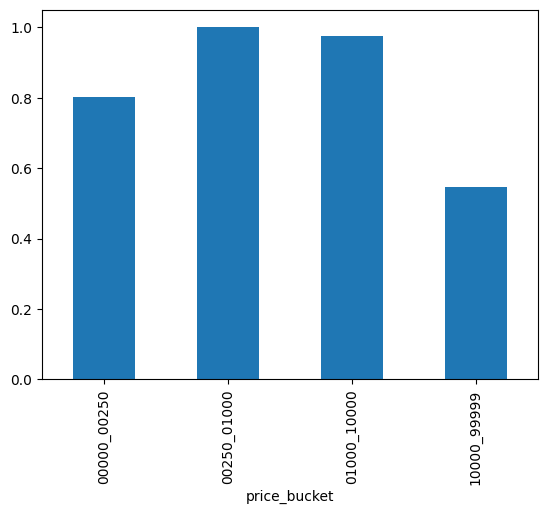

In [52]:
oddlot_price_per_bucket=mt_roundlot.stats_df['3_pct_trading_oddlot_per_price_bucket']#.toPandas()#.sort_values("price_bucket")

oddlot_price_per_bucket['odd lot pct'].plot.bar()
oddlot_price_per_bucket.sort_values("price_bucket").style.set_caption(f"Experimentation findings: {captions[2]}").format(
    {"round lot": "{:,.2f}", 
      "odd lot": "{:,.2f}", 
      "total": "{:,.2f}", 
      "odd lot pct": "{:,.2%}"
                     }).set_table_styles([{
    'selector': 'caption',
    'props': [
        ('color', 'blue'),
        ('font-size', '14px')
    ]
}])

is_odd_lot,odd lot,round lot,total,oddlot_pct,roundlot_pct
date_est_mt_roundlot_bbo,,,,,
2022-06-01,"795,461.00","27,818.50","823,279.50",96.62%,3.38%
2022-06-02,"710,242.50","25,398.50","735,641.00",96.55%,3.45%
2022-06-03,"575,635.50","17,762.00","593,397.50",97.01%,2.99%
2022-06-06,"771,919.00","357,590.00","1,129,509.00",68.34%,31.66%
2022-06-07,"819,418.50","210,796.00","1,030,214.50",79.54%,20.46%
2022-06-08,"718,777.00","174,090.00","892,867.00",80.50%,19.50%


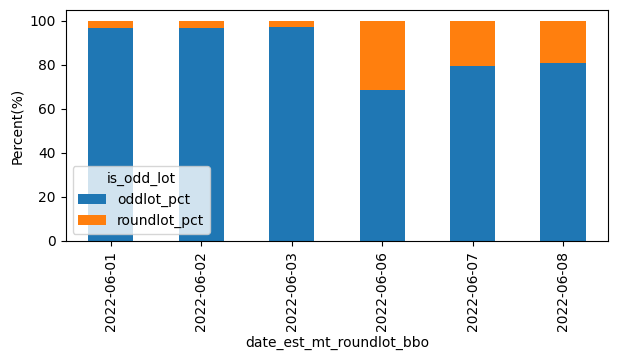

In [72]:
AMZN_pre_post_split=mt_roundlot.stats_df['3A_AMZN_split']#.toPandas()#.sort_values("price_bucket")
AMZN_pre_post_split["roundlot_pct"]=1-AMZN_pre_post_split["oddlot_pct"]
(AMZN_pre_post_split[['oddlot_pct','roundlot_pct']]*100).plot(kind="bar", ylabel='Percent(%)',stacked=True,figsize=(7,3))
AMZN_pre_post_split.style.set_caption(f"Experimentation findings: {captions[3]}").format(
    {"round lot": "{:,.2f}", 
      "odd lot": "{:,.2f}", 
      "total": "{:,.2f}", 
      "oddlot_pct": "{:,.2%}", 
      "roundlot_pct": "{:,.2%}"
                     }).set_table_styles([{
    'selector': 'caption',
    'props': [
        ('color', 'blue'),
        ('font-size', '14px')
    ]
}])